## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Helpers/Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

# trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# fun ones
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Reusable Function for ML Experimentation

5-fold cross validation + train/test splits to generate images

Target metrics to minimize are cross validation RMSE + MAE

In [2]:
# Helper Function
def doMLRegression(model, X_train, y_train, X_test, y_test):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate the model
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_mse)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

    # Print cross-validation metrics
    print("CROSS-VALIDATION METRICS (Training Data)")
    print(f"Mean R2: {np.mean(cv_r2)}")
    print(f"Mean MSE: {np.mean(-cv_mse)}")
    print(f"Mean RMSE: {np.mean(cv_rmse)}")
    print(f"Mean MAE: {np.mean(-cv_mae)}")
    print()
    
    # fit the model
    model.fit(X_train, y_train)

    # predict the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # get the TRAIN metrics
    resids = y_train - train_preds
    r2 = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_train, train_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, train_preds)

    # Print releveant metrics.
    print("TRAINING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")
    
    # get the TEST metrics
    resids = y_test - test_preds
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)

    # Print releveant metrics.
    print()
    print("TESTING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")
    
    # Predicted vs Actual Graph
    plt.scatter(test_preds, y_test)
    plt.xlabel("Predictions")
    plt.ylabel("Observed")
    plt.title("Predicted vs Actual Plot")
    plt.plot(y_test, y_test)
    plt.show()

    # Residual Graph
    plt.scatter(test_preds, resids)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.plot(test_preds, np.zeros(len(test_preds)))
    plt.show()

## Load data

Exclude 2022 as a holdout set to evaluation model performance

In [3]:
df = pd.read_csv("output/data/ml_soccer_data.csv")
df = df.loc[df.season_name != 2022]
print(df.shape)
df.head()

(2927, 58)


,season_name,player_id,player_name,minutes_played,offensive_goals_added,offensive_goals_added_90,player_age,guaranteed_compensation_1,minutes_played_1,share_team_touches_1,attempted_passes_1,completed_passes_1,total_distance_yds_1,total_vertical_distance_yds_1,xcompleted_passes_1,goals_added_above_avg_Dribbling_1,goals_added_above_avg_Fouling_1,goals_added_above_avg_Interrupting_1,goals_added_above_avg_Passing_1,goals_added_above_avg_Receiving_1,goals_added_above_avg_Shooting_1,guaranteed_compensation_2,minutes_played_2,share_team_touches_2,attempted_passes_2,completed_passes_2,total_distance_yds_2,total_vertical_distance_yds_2,xcompleted_passes_2,goals_added_above_avg_Dribbling_2,goals_added_above_avg_Fouling_2,goals_added_above_avg_Interrupting_2,goals_added_above_avg_Passing_2,goals_added_above_avg_Receiving_2,goals_added_above_avg_Shooting_2,guaranteed_compensation_3,minutes_played_3,share_team_touches_3,attempted_passes_3,completed_passes_3,total_distance_yds_3,total_vertical_distance_yds_3,xcompleted_passes_3,goals_added_above_avg_Dribbling_3,goals_added_above_avg_Fouling_3,goals_added_above_avg_Interrupting_3,goals_added_above_avg_Passing_3,goals_added_above_avg_Receiving_3,goals_added_above_avg_Shooting_3,played_two_years_ago,played_three_years_ago,primary_position_AM,primary_position_CB,primary_position_CM,primary_position_DM,primary_position_FB,primary_position_ST,primary_position_W
0,2014,0Oq60APM6D,Jason Hernandez,1868.0,-1.202600,-0.057941,30.0,208333.0,1817.0,0.064367,513.0,412.0,12260.3289,5384.6294,422.5266,0.1371,0.15161,-1.1739,-0.5978,-0.4063,-0.2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
1,2014,0Oq60VgM6D,Jeff Larentowicz,3211.0,0.071294,0.001998,30.0,231000.0,3024.0,0.092425,1217.0,928.0,24863.7753,8774.1994,962.7394,-0.4790,0.26440,-1.1032,0.0300,0.3525,0.1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,False
2,2014,0Oq67EgQ6D,Matt Besler,2415.0,1.094000,0.040770,26.0,180000.0,2811.0,0.113450,1605.0,1242.0,44430.6794,20073.7718,1242.5560,0.1821,0.25460,-1.8372,1.9678,-0.3481,-0.2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
3,2014,0Oq67k7Q6D,Tristan Bowen,69.0,-0.016700,-0.021783,22.0,156364.0,1259.0,0.053732,380.0,236.0,6457.6914,728.7155,270.9217,-0.4333,-0.16740,0.2524,0.0546,-0.9820,-0.3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,True,False
4,2014,0Oq67xxQ6D,Brandon Barklage,970.0,0.263000,0.024402,27.0,71428.5,2011.0,0.079036,1063.0,795.0,22768.3239,10058.4741,808.8326,-0.4377,-0.05840,0.6478,0.6542,-0.1870,-0.0851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False


In [4]:
df.season_name.value_counts()

season_name
2021    465
2020    419
2019    389
2018    357
2016    334
2014    328
2017    321
2015    314
Name: count, dtype: int64

## Predict offensive_goals_added_90

In [5]:
# Create our train/test set
target_cols = ['season_name', 'player_id', 'player_name', 'minutes_played', 'offensive_goals_added', 'offensive_goals_added_90']

X = df.drop(columns=target_cols)
y = df["offensive_goals_added_90"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25,
                                                    random_state=42,)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2195, 52) (2195,)
(732, 52) (732,)


### Model Experimentation

Linear models will use a StandardScaler to normalize the input features

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.08039607799472048
Mean MSE: 0.009116379808098436
Mean RMSE: 0.09253771651896914
Mean MAE: 0.05065795221588559

TRAINING SET METRICS
The r2 is 0.09360735427784472.
The mean squared error is 0.008835180053862138.
The root mean squared error is 0.09399563848318782.
The mean absolute error is 0.04937400542533979.

TESTING SET METRICS
The r2 is 0.08865682949765163.
The mean squared error is 0.007801694513870276.
The root mean squared error is 0.08832720143800706.
The mean absolute error is 0.04883059189902383.


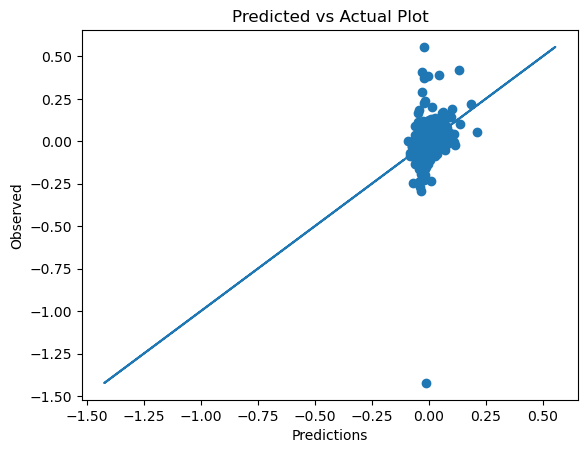

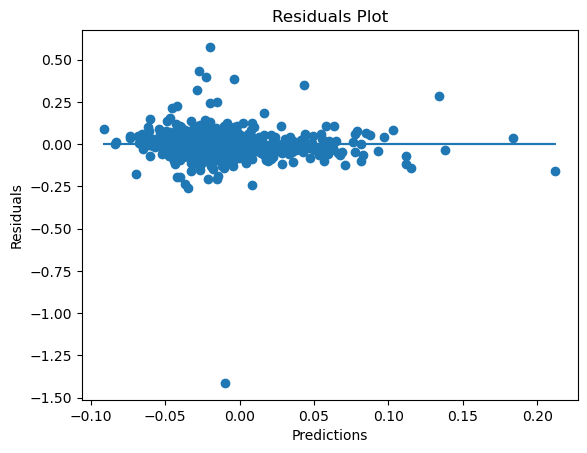

In [6]:
lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LinearRegression())
])
doMLRegression(lr, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.08299044815290169
Mean MSE: 0.009097877593675686
Mean RMSE: 0.0924248758035449
Mean MAE: 0.05049232255941477

TRAINING SET METRICS
The r2 is 0.0934298663358174.
The mean squared error is 0.008836910140632592.
The root mean squared error is 0.09400484104891935.
The mean absolute error is 0.04931724629950045.

TESTING SET METRICS
The r2 is 0.08968785925752132.
The mean squared error is 0.007792868223750849.
The root mean squared error is 0.0882772236975702.
The mean absolute error is 0.04877884580157569.


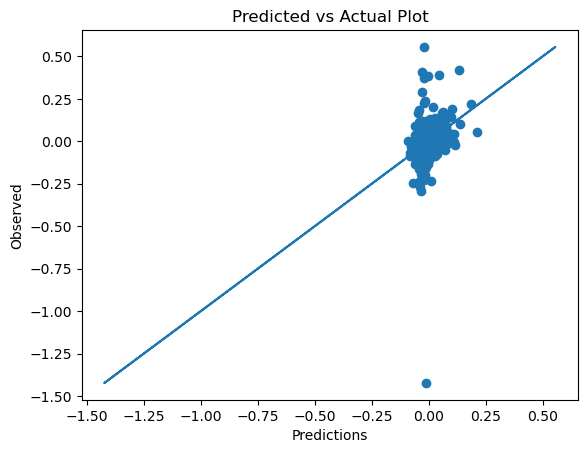

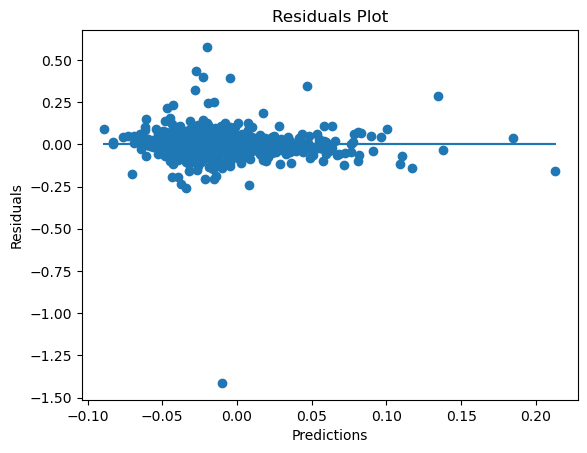

In [7]:
ridge = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
doMLRegression(ridge, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.002169371159895528
Mean MSE: 0.009754002575214476
Mean RMSE: 0.09620202333219523
Mean MAE: 0.05568215939844136

TRAINING SET METRICS
The r2 is 0.0.
The mean squared error is 0.00974762989920647.
The root mean squared error is 0.09873008608932979.
The mean absolute error is 0.05565050204125631.

TESTING SET METRICS
The r2 is -0.0013965563735023334.
The mean squared error is 0.008572610486301558.
The root mean squared error is 0.09258839282707934.
The mean absolute error is 0.05281610045269561.


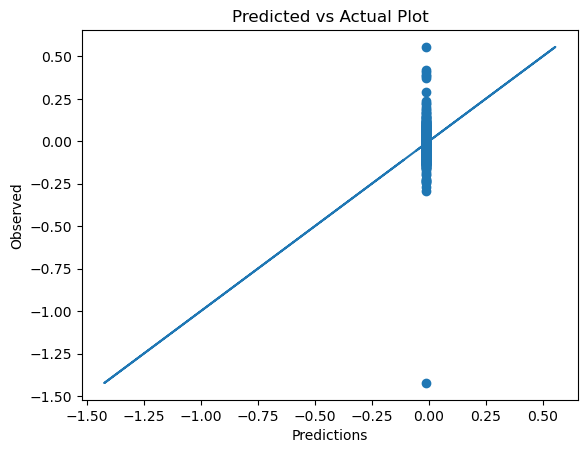

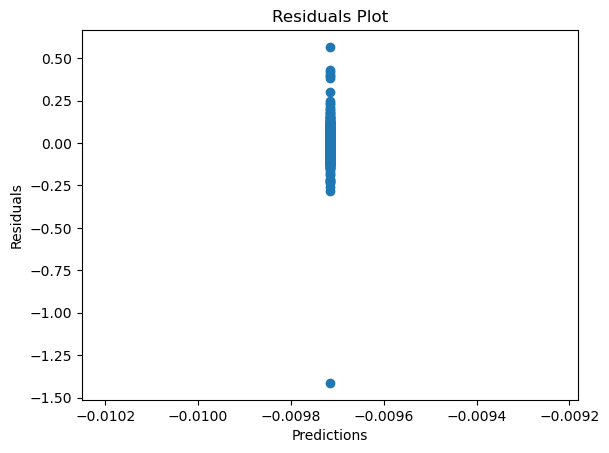

In [8]:
en = Pipeline([
    ('scaler', StandardScaler()), 
    ('en', ElasticNet())
])
doMLRegression(en, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.002169371159895528
Mean MSE: 0.009754002575214476
Mean RMSE: 0.09620202333219523
Mean MAE: 0.05568215939844136

TRAINING SET METRICS
The r2 is 0.0.
The mean squared error is 0.00974762989920647.
The root mean squared error is 0.09873008608932979.
The mean absolute error is 0.05565050204125631.

TESTING SET METRICS
The r2 is -0.0013965563735023334.
The mean squared error is 0.008572610486301558.
The root mean squared error is 0.09258839282707934.
The mean absolute error is 0.05281610045269561.


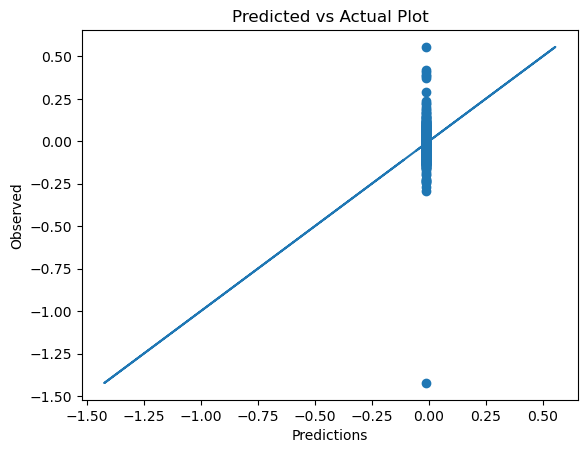

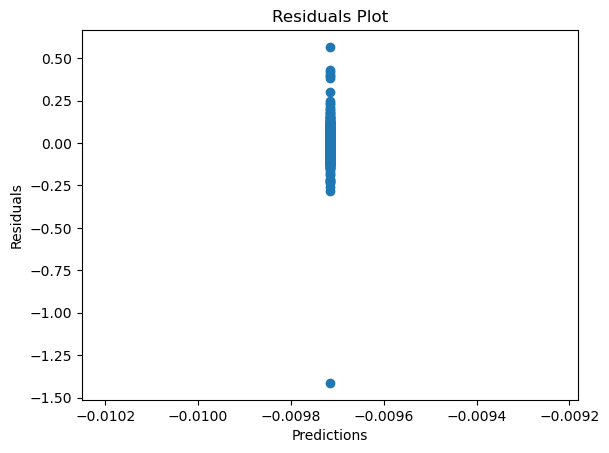

In [9]:
sgd = Pipeline([
    ('scaler', StandardScaler()), 
    ('sgd', SGDRegressor())
])
doMLRegression(en, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.03725548100374136
Mean MSE: 0.010047008248705077
Mean RMSE: 0.09773327200940876
Mean MAE: 0.056272070973156875

TRAINING SET METRICS
The r2 is 0.09104131709869456.
The mean squared error is 0.008860192834592098.
The root mean squared error is 0.09412859732616916.
The mean absolute error is 0.053169244296521784.

TESTING SET METRICS
The r2 is -0.028074933405656477.
The mean squared error is 0.00880099486933917.
The root mean squared error is 0.09381361771800067.
The mean absolute error is 0.05493110578979345.


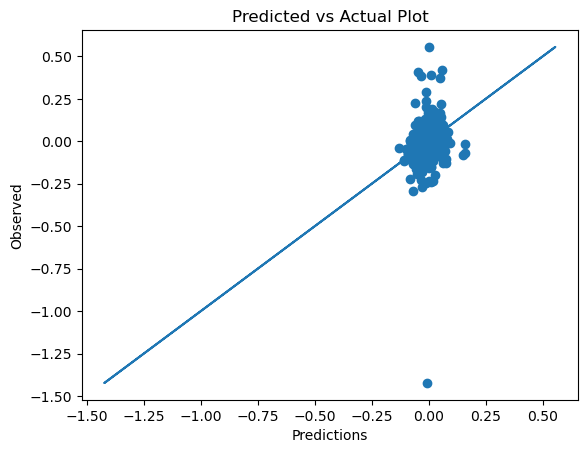

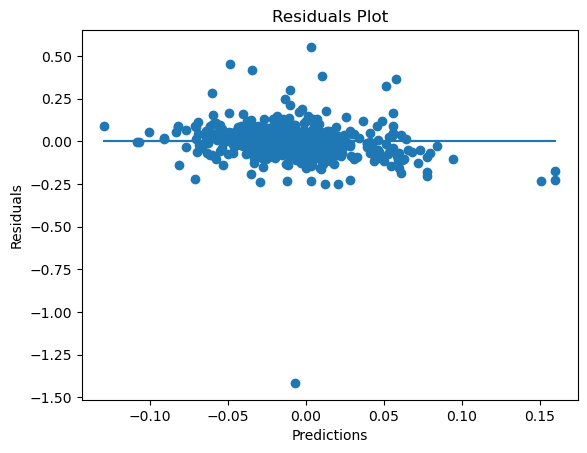

In [10]:
knn = KNeighborsRegressor(n_neighbors=15)
doMLRegression(knn, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.06097353313230151
Mean MSE: 0.00918453651413343
Mean RMSE: 0.09325209960683786
Mean MAE: 0.05168928562075029

TRAINING SET METRICS
The r2 is 0.8731332471435432.
The mean squared error is 0.0012366501533588356.
The root mean squared error is 0.035166036929953244.
The mean absolute error is 0.019070068975499493.

TESTING SET METRICS
The r2 is 0.03279227825881548.
The mean squared error is 0.008279931666489318.
The root mean squared error is 0.09099412984632205.
The mean absolute error is 0.05110697865599102.


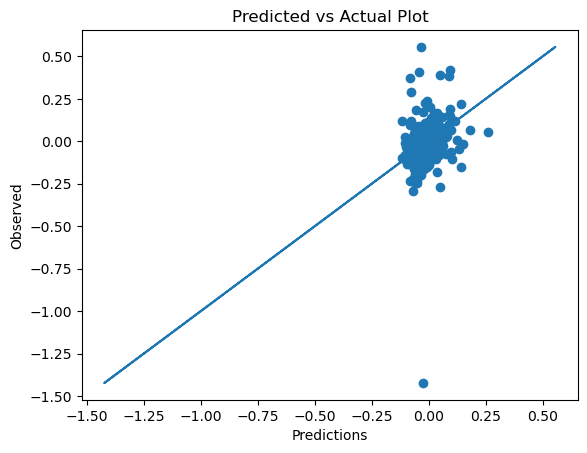

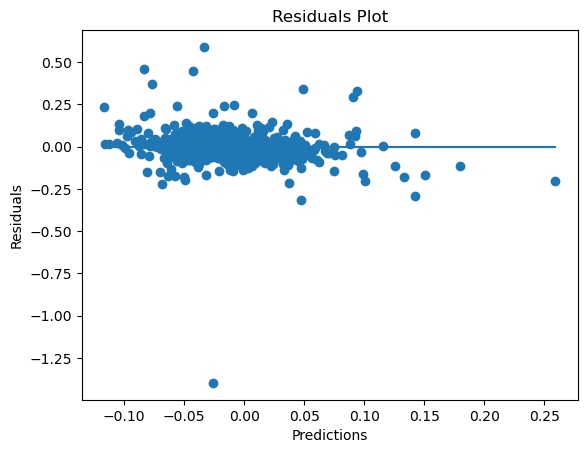

In [11]:
rf = RandomForestRegressor(random_state=42)
doMLRegression(rf, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.20525032557054956
Mean MSE: 0.010919374774774695
Mean RMSE: 0.10329185711348703
Mean MAE: 0.061745945191974516

TRAINING SET METRICS
The r2 is -0.002130965822889186.
The mean squared error is 0.009768401765375854.
The root mean squared error is 0.09883522532668125.
The mean absolute error is 0.07071699357207013.

TESTING SET METRICS
The r2 is -0.4994656612325956.
The mean squared error is 0.012836408283530405.
The root mean squared error is 0.11329787413508871.
The mean absolute error is 0.07236497266326643.


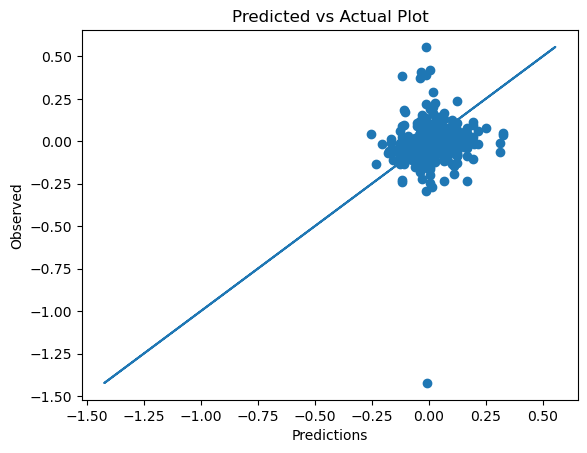

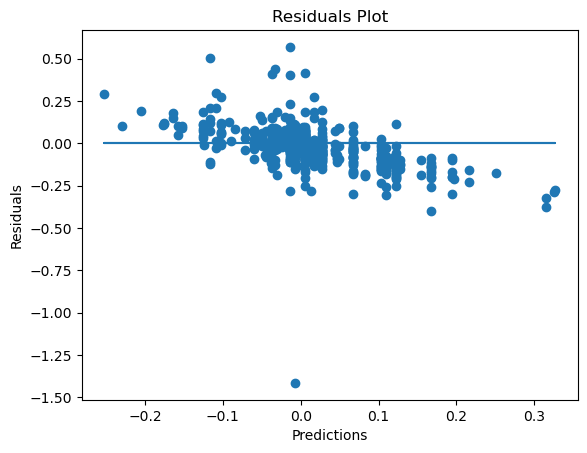

In [12]:
ada = AdaBoostRegressor(random_state=42)
doMLRegression(ada, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.1736835422951834
Mean MSE: 0.010841867572430495
Mean RMSE: 0.102451792153713
Mean MAE: 0.05779084866495442

TRAINING SET METRICS
The r2 is 0.9809905950886724.
The mean squared error is 0.00018529664367977902.
The root mean squared error is 0.013612370979362083.
The mean absolute error is 0.009366328672939093.

TESTING SET METRICS
The r2 is 0.006414735528739501.
The mean squared error is 0.008505740710839952.
The root mean squared error is 0.09222657269377385.
The mean absolute error is 0.0563069339363428.


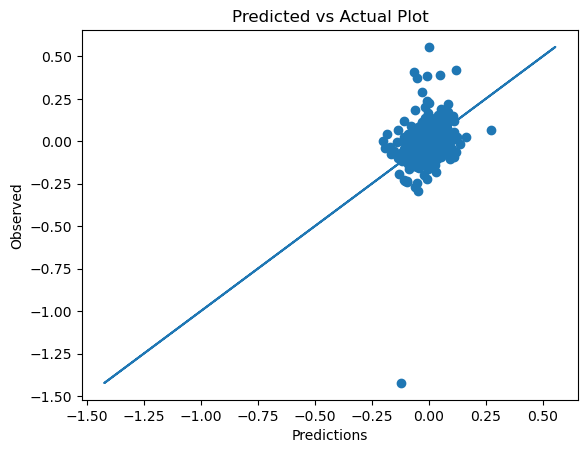

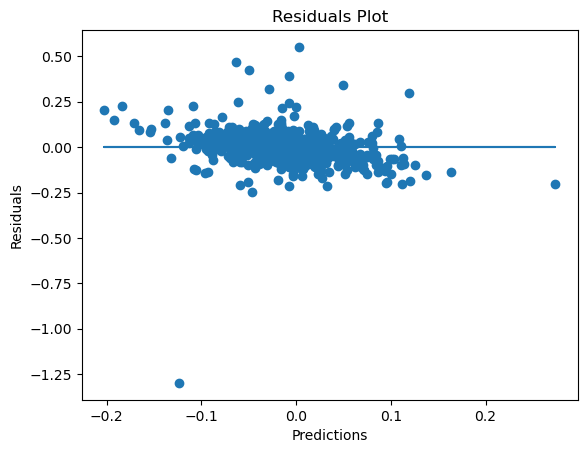

In [13]:
xgb = XGBRegressor(random_state=42)
doMLRegression(xgb, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.04298093648876646
Mean MSE: 0.010024808016436102
Mean RMSE: 0.09775131595306358
Mean MAE: 0.05514231744198148

TRAINING SET METRICS
The r2 is 0.7058296149932746.
The mean squared error is 0.0028674640403526354.
The root mean squared error is 0.05354870717722918.
The mean absolute error is 0.02584143806921314.

TESTING SET METRICS
The r2 is -0.04044074960709909.
The mean squared error is 0.00890685435623821.
The root mean squared error is 0.09437613234413778.
The mean absolute error is 0.05378015959907029.


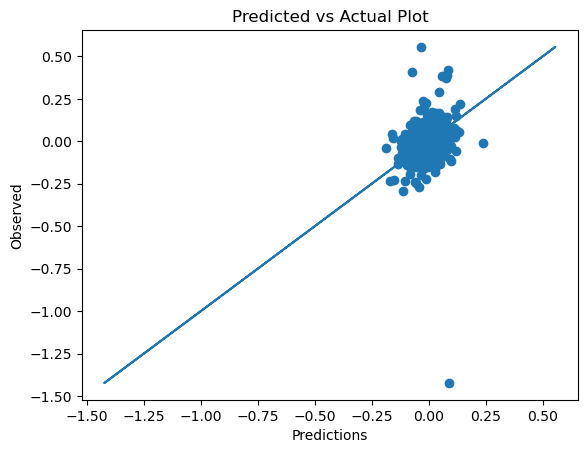

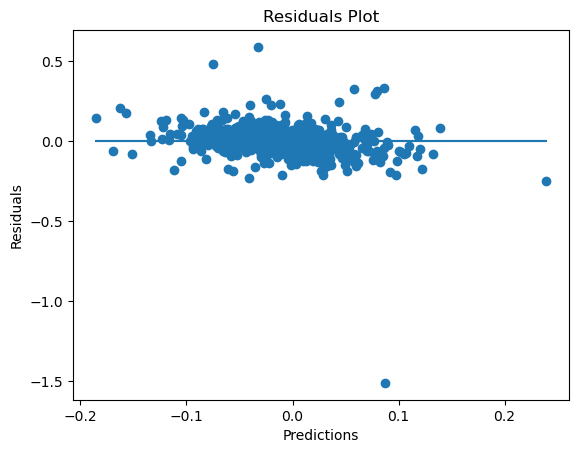

In [14]:
lgb = LGBMRegressor(random_state=42, verbosity=-1)
doMLRegression(lgb, X_train, y_train, X_test, y_test)

In [15]:
fi = pd.DataFrame(list(zip(X.columns, lgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
3,share_team_touches_1,216
12,goals_added_above_avg_Passing_1,176
7,total_vertical_distance_yds_1,175
1,guaranteed_compensation_1,173
9,goals_added_above_avg_Dribbling_1,169
13,goals_added_above_avg_Receiving_1,153
0,player_age,150
2,minutes_played_1,147
14,goals_added_above_avg_Shooting_1,144
5,completed_passes_1,142


## Results

Ridge model performs the best in MAE/RMSE. ElasticNet & SGDRegressor don't seem to have been fit correctly - noticed this was also an issue with Lasso.

Tree and boosted models do not perform as well as the linear models.

Feature importances seem to make sense - data from most recent year is most important, as well as passing statistics. Salary is an important feature

## Model Selection

In [16]:
import pickle

# Initialize and train the model on the entire dataset
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
model.fit(X, y)

# Get absolute coefficients
coef_abs = np.abs(model["ridge"].coef_)

# Normalize the coefficients
coef_normalized = coef_abs / np.sum(coef_abs)
fi = pd.DataFrame(list(zip(X.columns, coef_normalized)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
5,completed_passes_1,0.112463
8,xcompleted_passes_1,0.072817
36,xcompleted_passes_3,0.067609
4,attempted_passes_1,0.065195
32,attempted_passes_3,0.053333
33,completed_passes_3,0.037413
15,guaranteed_compensation_2,0.035553
12,goals_added_above_avg_Passing_1,0.034723
3,share_team_touches_1,0.033751
13,goals_added_above_avg_Receiving_1,0.033630


In [17]:
# Save the model to a file
with open('models/eval/oga90_model_eval.pkl', 'wb') as file:
    pickle.dump(model, file)